In [1]:
from gears import PertData, GEARS

In [2]:
import torch

In [3]:
pert_data = PertData('./data')
pert_data.load(data_name = 'norman')
pert_data.prepare_split(split = 'simulation', seed = 1)
pert_data.get_dataloader(batch_size = 32, test_batch_size = 128)

Found local copy...
Found local copy...
Found local copy...
These perturbations are not in the GO graph and their perturbation can thus not be predicted
['RHOXF2BB+ctrl' 'LYL1+IER5L' 'ctrl+IER5L' 'KIAA1804+ctrl' 'IER5L+ctrl'
 'RHOXF2BB+ZBTB25' 'RHOXF2BB+SET']
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:43
combo_seen2:19
unseen_single:36
Done!
Creating dataloaders....
Done!


In [4]:
pert_data.adata.var["gene_name"].reset_index()

,gene_id,gene_name
0,ENSG00000239945,RP11-34P13.8
1,ENSG00000223764,RP11-54O7.3
2,ENSG00000187634,SAMD11
3,ENSG00000187642,PERM1
4,ENSG00000188290,HES4
...,...,...
5040,ENSG00000198786,MT-ND5
5041,ENSG00000198695,MT-ND6
5042,ENSG00000198727,MT-CYB
5043,ENSG00000273554,AC136616.1


In [5]:
gears_model = GEARS(pert_data, device = 'cuda')

In [6]:
gears_model.load_pretrained("norman_model")

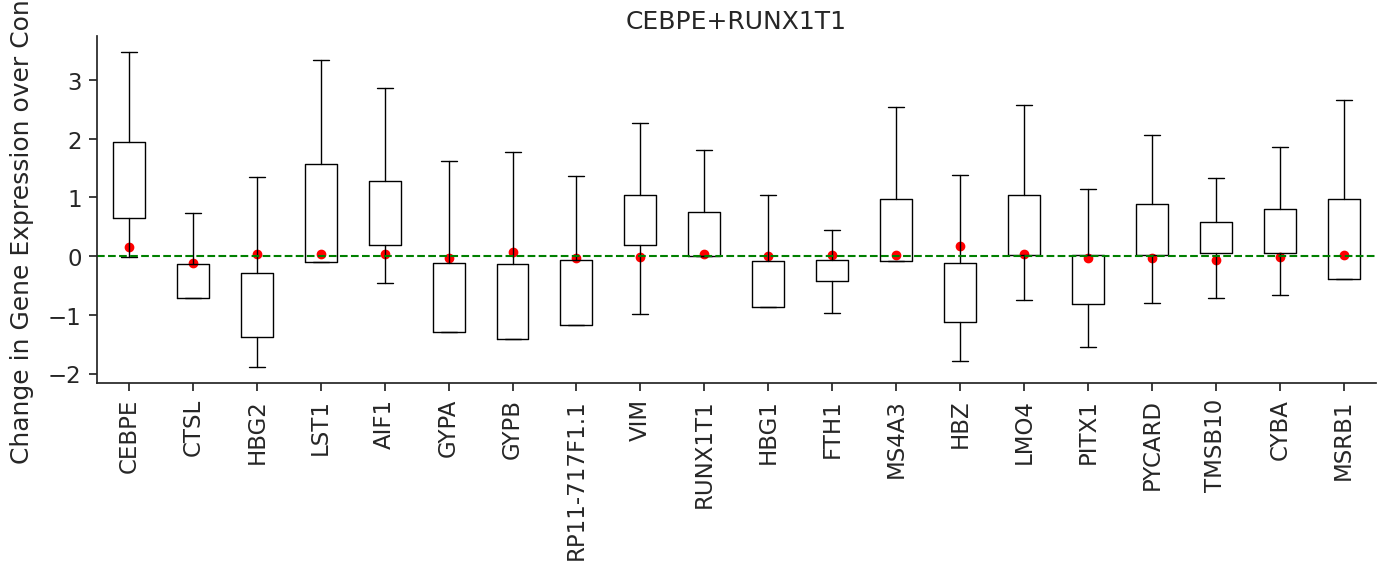

In [7]:
gears_model.plot_perturbation('CEBPE+RUNX1T1')


In [26]:
import importlib 
from gears import utils
from gears import gears
importlib.reload(utils)
importlib.reload(gears)
gears_model.train(epochs = 1, lr = 1e-3)

Start Training...
Epoch 1 Step 1 Train Loss: 0.3884
Epoch 1 Step 51 Train Loss: 0.4229
Epoch 1 Step 101 Train Loss: 0.4610
Epoch 1 Step 151 Train Loss: 0.5906


KeyboardInterrupt: 

In [14]:
pred = gears_model.predict([['FEV'], ['FEV', 'AHR']])

In [15]:
pred['FEV']

array([ 1.5831477e-11,  6.4478375e-02,  1.0530336e-01, ...,
        3.5392382e+00, -2.6021125e-02,  4.2876899e-18], dtype=float32)

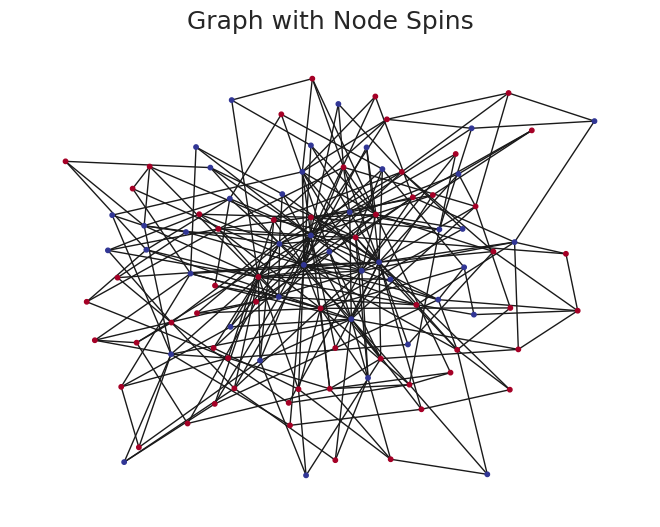

Ising Energy: 8.394574835449449


In [9]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def ising_energy(graph, spins, J_matrix, temp = 1):
    """
    Compute the Ising energy of a spin configuration on a graph.

    Parameters:
    - graph: NetworkX graph object
    - spins: NumPy array representing the spin configuration of nodes
    - J_matrix: NumPy array representing the coupling strengths between nodes

    Returns:
    - energy: Ising energy of the spin configuration
    """
    energy = 0.0
    nodes = list(graph.nodes())

    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            if graph.has_edge(nodes[i], nodes[j]):
                energy += J_matrix[i, j] * spins[i] * spins[j]

    return -energy/temp

# Example usage with a random graph of 1000 nodes
G = nx.barabasi_albert_graph(100, m=3)   

# Set random spins and coupling strengths
p = .5
spins = np.random.choice([-1, 1], size=len(G.nodes()),p = [p,1-p])
J_matrix = np.random.uniform(low = 0, high = 1, size = (len(G.nodes()), len(G.nodes())))

# Plot the graph (note: visualization may not be very informative for a large graph)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=10, node_color=spins, cmap=plt.cm.RdYlBu, with_labels=False)
plt.title('Graph with Node Spins')
plt.show()

# Compute Ising energy
energy = ising_energy(G, spins, J_matrix, temp = 1)
print("Ising Energy:", energy)

In [10]:
nreps = 1000
temps = [10,1,.1]
probs = [.1,.3,.5,.7,.9]
energies = np.zeros((len(temps),len(probs),nreps))
G = nx.barabasi_albert_graph(100, m=2)   
J_matrix = np.random.uniform(low = 0, high = 1, size = (len(G.nodes()), len(G.nodes())))
for i, temp in enumerate(temps):
    for j, p in enumerate(probs):
        for rep in range(nreps):
            spins = np.random.choice([-1, 1], size=len(G.nodes()),p = [p,1-p])
            energies[i,j,rep] = ising_energy(G, spins, J_matrix, temp = temp)

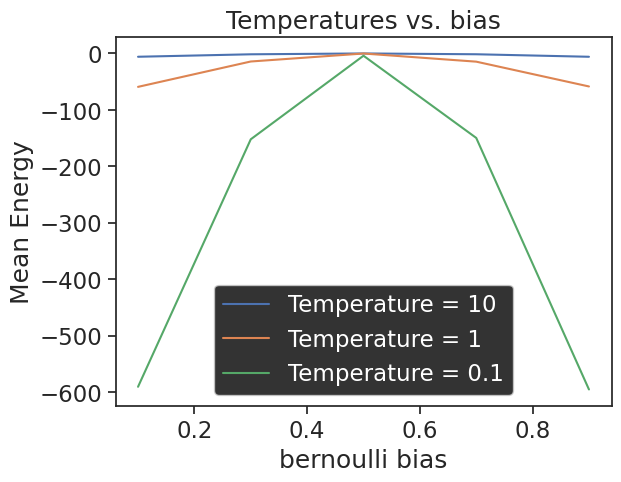

In [11]:
means = energies.mean(2)
#std_devs = energies.std(2)

# Scatterplot with error bars
for i, temp in enumerate(temps):
    plt.plot(probs, means[i], label=f'Temperature = {temp}')

plt.xlabel('bernoulli bias')
plt.ylabel('Mean Energy')
plt.title('Temperatures vs. bias')
legend = plt.legend()
for text in legend.get_texts():
    text.set_color("white")
plt.savefig("ising_energy.png")
plt.show()



In [12]:
import pickle
with open("norman_node_map.pkl", 'wb') as handle:
    pickle.dump(pert_data.node_map, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
def ising_loss_fct(pred, ctrl, graph, reg = 1, temperature = 1000, cutoff = 1e-2):
    """
    Ising loss function
    
    Args:
        pred (torch.tensor): predicted values for the batch 
        ctrl (torch.tensor): initial value
        graph (torch.tensor): weighted adjacency matrix
        reg (float): regularization penalty 
        temperature (float): temperature of the ising model
        cutoff (float): cutoff for sign change
    """
    diffs = pred - ctrl

    adj = graph#torch.tensor(adjacency_matrix).cuda()
    #signs = torch.tensor(np.random.choice([-1,1], (32,5045),p = [.5,.5])).cuda()

    signs = torch.sign(torch.abs(diffs)- cutoff)
      
    for i in range(signs.shape[0]):
        spins = torch.outer(signs[i], signs[i])
        energy += (torch.sum(-0.5 * adj * spins)).detach().cpu().numpy()
    ising_loss = torch.tensor(energy/signs.shape[0]/temperature).cuda()


    return reg*ising_loss
    
    
def loss_fct(pred, y, perts, ctrl = None, direction_lambda = 1e-3, dict_filter = None, 
             ising = False, ising_lambda = 1, ising_cutoff = 1e-1, ising_temperature = 1, ising_graph = None):
    """
    Main MSE Loss function, includes direction loss

    Args:
        pred (torch.tensor): predicted values
        y (torch.tensor): true values
        perts (list): list of perturbations
        ctrl (str): control perturbation
        direction_lambda (float): direction loss weight hyperparameter
        dict_filter (dict): dictionary of perturbations to conditions
        
        #new args
        ising (bool): whether to use ising loss
        ising_lambda (float): regularization for ising loss
        ising_temperature (float)
        ising_cutoff (float)
        ising_graph (nwx object or None)

    """
    
    gamma = 2
    mse_p = torch.nn.MSELoss()
    perts = np.array(perts)
    losses = torch.tensor(0.0, requires_grad=True).to(pred.device)

    for p in set(perts):
        pert_idx = np.where(perts == p)[0]
        
        # during training, we remove the all zero genes into calculation of loss.
        # this gives a cleaner direction loss. empirically, the performance stays the same.
        if p!= 'ctrl':
            retain_idx = dict_filter[p]
            pred_p = pred[pert_idx][:, retain_idx]
            y_p = y[pert_idx][:, retain_idx]
        else:
            pred_p = pred[pert_idx]
            y_p = y[pert_idx]
        losses = losses + torch.sum((pred_p - y_p)**(2 + gamma))/pred_p.shape[0]/pred_p.shape[1]
                         
        ## direction loss
        if (p!= 'ctrl'):
            losses = losses + torch.sum(direction_lambda *
                                (torch.sign(y_p - ctrl[retain_idx]) -
                                 torch.sign(pred_p - ctrl[retain_idx]))**2)/\
                                 pred_p.shape[0]/pred_p.shape[1]
        else:
            losses = losses + torch.sum(direction_lambda * (torch.sign(y_p - ctrl) -
                                                torch.sign(pred_p - ctrl))**2)/\
                                                pred_p.shape[0]/pred_p.shape[1]
    ## ising loss
    if ising:
        losses += ising_loss_fct(pred = pred, ctrl = ctrl, reg = ising_lambda, 
                                 temperature = ising_temperature, cutoff = ising_cutoff, graph = ising_graph)
    return losses/(len(set(perts)))

In [14]:
train_loader = gears_model.dataloader['train_loader']
val_loader = gears_model.dataloader['val_loader']
testbatch = None
for step, batch in enumerate(train_loader):
    if step==10:
        testbatch = batch
        break

In [15]:
gears_model.num_genes
pred = gears_model.model.forward(batch.cuda())
pred.size()

torch.Size([32, 5045])

In [16]:
gears_model.ctrl_expression

tensor([0.0000e+00, 3.0636e-03, 7.3341e-03,  ..., 3.7373e+00, 8.7354e-04,
        0.0000e+00], device='cuda:0')

In [17]:
# Create a Barabasi-Albert graph
test_graph = nx.barabasi_albert_graph(5045, m=2)

# Add random weights to edges
for edge in test_graph.edges():
    test_graph[edge[0]][edge[1]]['weight'] = np.random.uniform(0.1, 1.0)
spins = torch.tensor(np.random.choice([-1,1], 5045,[.5,.5]))
# Print the adjacency matrix
adjacency_matrix = nx.to_numpy_array(test_graph)
np.save("test_adj_mat.np", adjacency_matrix) 
print("Adjacency Matrix:")
print(np.array(adjacency_matrix))

# Print the weights of the first few edges for verification
for edge in list(test_graph.edges(data=True))[:5]:
    print(edge)


Adjacency Matrix:
[[0.         0.99474459 0.87446581 ... 0.         0.         0.        ]
 [0.99474459 0.         0.         ... 0.         0.         0.        ]
 [0.87446581 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(0, 1, {'weight': 0.9947445940547197})
(0, 2, {'weight': 0.8744658110652099})
(0, 3, {'weight': 0.5351808616241891})
(0, 4, {'weight': 0.44942623404460236})
(0, 6, {'weight': 0.9005911790616073})


In [18]:
#check that torch.outer matches spins
print(torch.outer(spins, spins))
spins

tensor([[ 1, -1, -1,  ..., -1,  1, -1],
        [-1,  1,  1,  ...,  1, -1,  1],
        [-1,  1,  1,  ...,  1, -1,  1],
        ...,
        [-1,  1,  1,  ...,  1, -1,  1],
        [ 1, -1, -1,  ..., -1,  1, -1],
        [-1,  1,  1,  ...,  1, -1,  1]])


tensor([-1,  1,  1,  ...,  1, -1,  1])

In [19]:
energy = torch.sum(-0.5 * torch.tensor(adjacency_matrix) * torch.outer(spins, spins)) /100
energy

tensor(-0.5501, dtype=torch.float64)

In [20]:
import importlib
from gears import utils
importlib.reload(utils)
loss = utils.loss_fct(pred,batch.y, batch.pert, gears_model.ctrl_expression, dict_filter = gears_model.dict_filter,
direction_lambda = 1, debugmode = True)

In [21]:
loss

tensor(2.1052, device='cuda:0', grad_fn=<DivBackward0>)

In [22]:
gears_model.ctrl_expression

tensor([0.0000e+00, 3.0636e-03, 7.3341e-03,  ..., 3.7373e+00, 8.7354e-04,
        0.0000e+00], device='cuda:0')

In [23]:
torch.cuda.empty_cache()

In [24]:
test_graph2 = nx.random_regular_graph(d = 2,n = 5045)
adjacency_matrix2 = nx.to_numpy_array(test_graph2)

adjacency_matrix3 = nx.to_numpy_array(nx.complete_graph(5045))

In [25]:
real_adj = np.load("adj_matrix_norman_10Mb.npy")

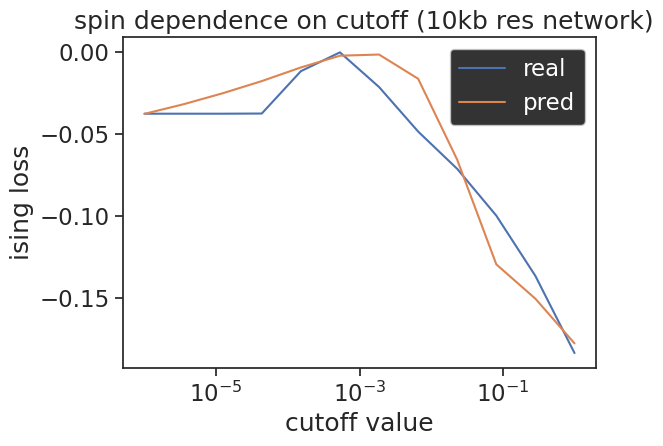

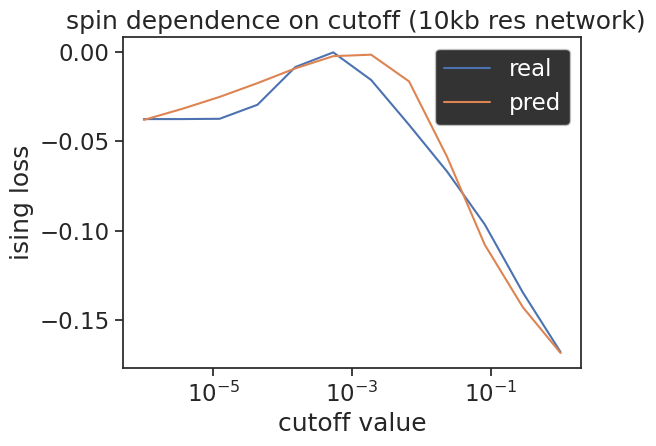

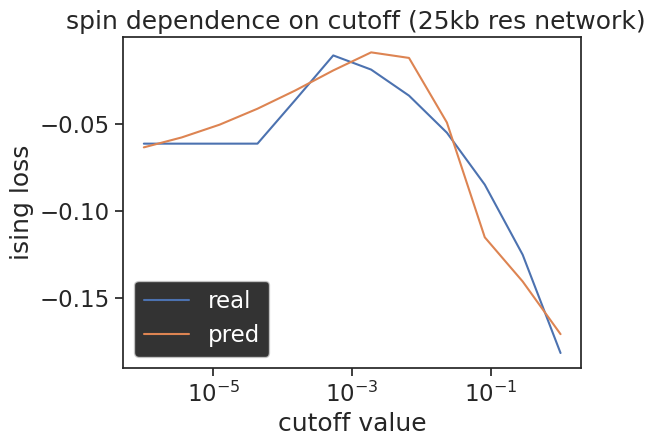

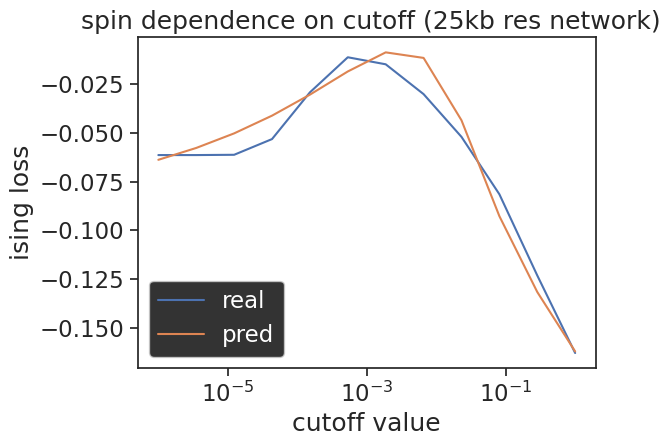

In [55]:
diffs_real = testbatch.y - gears_model.ctrl_expression
diffs_pred = pred - gears_model.ctrl_expression
for adj, kind in zip([real_adj, adj25],['10kb res', '25kb res']):
    for cutoff_method in ["sign", "sigmoid"]:
        for diffs, label in zip([diffs_real, diffs_pred], ["real","pred"]):

            adj = torch.tensor(adj).cuda()
            #signs = torch.tensor(np.random.choice([-1,1], (32,5045),p = [.5,.5])).cuda()

            temperature = 1000
            #example sensitiviy to cutoff 
            to_plot = []
            cutoffs = np.logspace(-6, 0, 12, base = 10)
            for cutoff in cutoffs:
                if cutoff_method== "sign":
                    signs = torch.sign(torch.abs(diffs)- cutoff)
                if cutoff_method== "indicator":
                    signs = 2*(torch.abs(diffs)> cutoff)-1
                if cutoff_method == "sigmoid":
                    d = torch.exp(-(torch.abs(diffs)/cutoff))
                    #d = torch.exp(-((torch.abs(diffs) - 1)/cutoff))
                    signs = 2*(2/(1+d)-1)-1
                energy = 0
                for i in range(signs.shape[0]):
                    spins = torch.outer(signs[i], signs[i])
                    energy += (torch.sum(-0.5 * adj * spins)).detach().cpu().numpy()
                    #energy+=ising_energy(test_graph, spins, adj)
                ising_loss = torch.tensor(energy/32/temperature).cuda()
                to_plot.append(ising_loss.cpu().numpy())
            plt.plot(cutoffs, to_plot, label = label)
            plt.xscale("log")
            plt.ylabel("ising loss")
            plt.xlabel("cutoff value")
            plt.title(f" spin dependence on cutoff ({kind} network)")
        legend = plt.legend()
        for text in legend.get_texts():
            text.set_color("white")
        plt.savefig(f"ising_cutoff_plot_{cutoff_method}_{kind}.png")
        plt.tight_layout()
        plt.show()

In [53]:
import pandas as pd
import scipy
real = torch.abs(diffs_real)
pred = torch.abs(diffs_pred)


print(real, pred)
print((toplot != 0).sum())

toplot = pd.DataFrame({'real':torch.abs(diffs_real).flatten().detach().cpu().numpy(), 'pred':torch.abs(diffs_pred).flatten().detach().cpu().numpy()})
w = scipy.stats.wilcoxon(toplot['real'], toplot['pred'])


tensor([[0.0000, 0.0031, 0.0073,  ..., 0.0425, 0.0009, 0.0000],
        [0.0000, 0.0031, 0.0073,  ..., 0.3399, 0.0009, 0.0000],
        [0.0000, 0.0031, 0.0073,  ..., 0.2861, 0.0009, 0.0000],
        ...,
        [0.0000, 0.0031, 0.0073,  ..., 0.3242, 0.0009, 0.0000],
        [0.0000, 0.0031, 0.0073,  ..., 0.7147, 0.0009, 0.0000],
        [0.0000, 0.0031, 0.0073,  ..., 0.0846, 0.0009, 0.0000]],
       device='cuda:0') tensor([[1.4466e-11, 3.4142e-02, 5.9658e-02,  ..., 1.4385e-02, 1.3001e-02,
         1.7788e-18],
        [3.2101e-12, 1.6095e-02, 2.8362e-02,  ..., 2.4664e-01, 1.1218e-02,
         7.3227e-19],
        [1.4808e-11, 3.4703e-02, 6.0156e-02,  ..., 4.2453e-01, 1.3607e-02,
         1.8461e-18],
        ...,
        [6.4499e-12, 2.0669e-02, 3.4167e-02,  ..., 1.5834e-01, 1.3918e-02,
         1.6180e-19],
        [1.4808e-11, 3.4703e-02, 6.0156e-02,  ..., 2.7863e-01, 1.3607e-02,
         1.8461e-18],
        [1.5147e-11, 3.2510e-02, 5.7052e-02,  ..., 6.8578e-02, 1.3026e-02,
     

0.0

,real,pred
0,0.000000,1.514742e-11
1,-0.003064,3.251026e-02
2,-0.007334,5.705177e-02
3,0.000000,-5.333243e-06
4,-0.214471,7.237116e-01
...,...,...
161435,-0.219832,3.032644e-01
161436,-0.099501,-3.653334e-01
161437,0.275402,1.334548e-02
161438,-0.000874,5.054142e-04


In [165]:
gears_model.predict([['CAD','BDNF']])['CAD_BDNF'] - gears_model.ctrl_expression.detach().cpu().numpy()

array([ 1.9102614e-11,  3.8316526e-02,  7.3196456e-02, ...,
       -1.4363861e-01, -1.5933288e-02,  2.3766719e-18], dtype=float32)

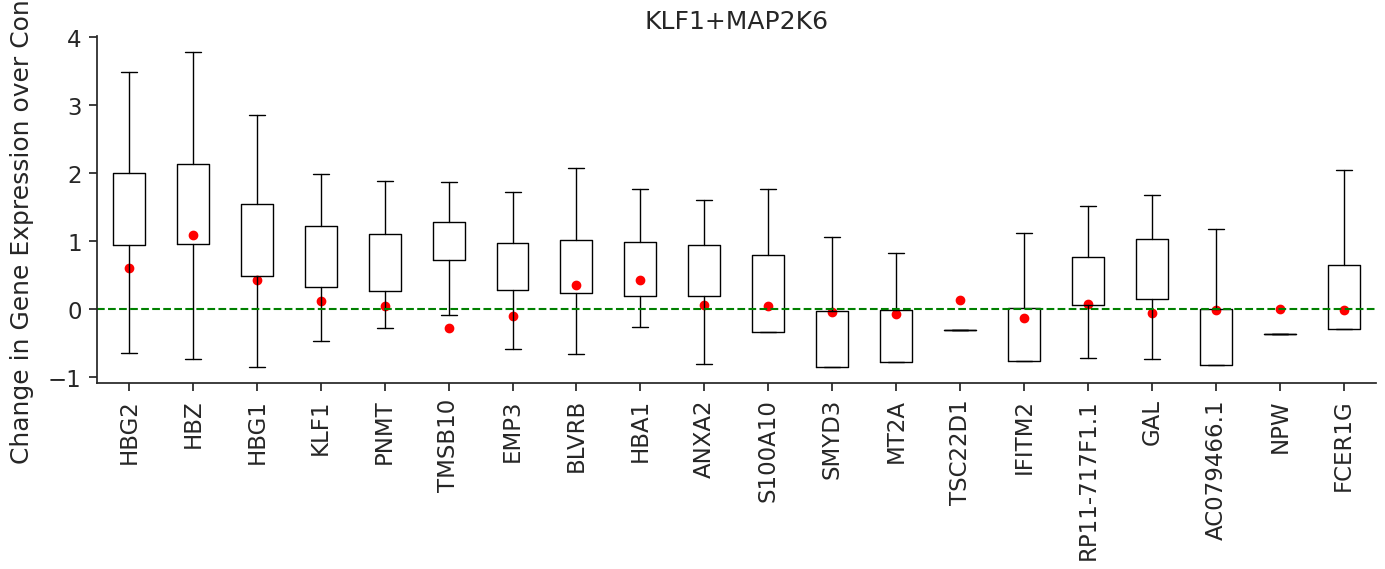

In [247]:
#pert_data.adata.obs['condition']
gears_model.plot_perturbation('KLF1+MAP2K6')

In [181]:
#gears_model.adata.uns['top_non_dropout_de_20']

In [216]:

importlib.reload(gears)
importlib.reload(utils)
from gears import GEARS

In [217]:
#new model 
gears_ising_model = GEARS(pert_data, device = 'cuda', 
                        weight_bias_track = False, 
                        proj_name = 'pertnet', 
                        exp_name = 'pertnet')
gears_ising_model.model_initialize(hidden_size = 64, ising = True, ising_lambda = 1, ising_cutoff = 1e-2, ising_temperature = 1000, ising_graph = torch.tensor(adjacency_matrix).cuda())

Found local copy...


In [214]:
gears_ising_model.config

{'hidden_size': 64,
 'num_go_gnn_layers': 1,
 'num_gene_gnn_layers': 1,
 'decoder_hidden_size': 16,
 'num_similar_genes_go_graph': 20,
 'num_similar_genes_co_express_graph': 20,
 'coexpress_threshold': 0.4,
 'uncertainty': False,
 'uncertainty_reg': 1,
 'direction_lambda': 0.1,
 'G_go': tensor([[   0,    0,    0,  ..., 9649, 9669, 9693],
         [   0,  126,  514,  ..., 9649, 9669, 9693]]),
 'G_go_weight': tensor([1.0000, 0.1739, 0.1600,  ..., 1.0000, 1.0000, 1.0000]),
 'G_coexpress': tensor([[   0,    1,    2,  ..., 5038, 5041, 5043],
         [   0,    1,    2,  ..., 5038, 5041, 5043]]),
 'G_coexpress_weight': tensor([1.0000, 1.0000, 0.9997,  ..., 1.0000, 1.0000, 1.0000]),
 'device': 'cuda',
 'num_genes': 5045,
 'num_perts': 9853,
 'no_perturb': False,
 'ising': True,
 'ising_lambda': 1,
 'ising_temperature': 1000,
 'ising_cutoff': 0.01,
 'ising_graph': tensor([[0.0000, 0.7728, 0.2442,  ..., 0.0000, 0.0000, 0.0000],
         [0.7728, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
  

In [215]:
gears_ising_model.tunable_parameters()

{'hidden_size': 'hidden dimension, default 64',
 'num_go_gnn_layers': 'number of GNN layers for GO graph, default 1',
 'num_gene_gnn_layers': 'number of GNN layers for co-expression gene graph, default 1',
 'decoder_hidden_size': 'hidden dimension for gene-specific decoder, default 16',
 'num_similar_genes_go_graph': 'number of maximum similar K genes in the GO graph, default 20',
 'num_similar_genes_co_express_graph': 'number of maximum similar K genes in the co expression graph, default 20',
 'coexpress_threshold': 'pearson correlation threshold when constructing coexpression graph, default 0.4',
 'uncertainty': 'whether or not to turn on uncertainty mode, default False',
 'uncertainty_reg': 'regularization term to balance uncertainty loss and prediction loss, default 1',
 'direction_lambda': 'regularization term to balance direction loss and prediction loss, default 1',
 'ising': 'whether or not to turn on ising mode',
 'ising_lambda': 'regularization term to balance ising loss and 

In [219]:
gears_ising_model.train(epochs = 1, lr = 1e-3)

Start Training...
Epoch 1 Step 1 Train Loss: 0.4494
Epoch 1 Step 51 Train Loss: 0.4165
Epoch 1 Step 101 Train Loss: 0.6719
Epoch 1 Step 151 Train Loss: 0.4742
Epoch 1 Step 201 Train Loss: 0.4846
Epoch 1 Step 251 Train Loss: 0.5209
Epoch 1 Step 301 Train Loss: 0.5271
Epoch 1 Step 351 Train Loss: 0.5419
Epoch 1 Step 401 Train Loss: 0.5352
Epoch 1 Step 451 Train Loss: 0.4263
Epoch 1 Step 501 Train Loss: 0.4925
Epoch 1 Step 551 Train Loss: 0.4804
Epoch 1 Step 601 Train Loss: 0.4942
Epoch 1 Step 651 Train Loss: 0.4415
Epoch 1 Step 701 Train Loss: 0.4732
Epoch 1 Step 751 Train Loss: 0.3779
Epoch 1 Step 801 Train Loss: 0.4408
Epoch 1 Step 851 Train Loss: 0.5400
Epoch 1 Step 901 Train Loss: 0.4890
Epoch 1 Step 951 Train Loss: 0.4544
Epoch 1 Step 1001 Train Loss: 0.4775
Epoch 1 Step 1051 Train Loss: 0.5239
Epoch 1 Step 1101 Train Loss: 0.5224
Epoch 1 Step 1151 Train Loss: 0.5316
Epoch 1 Step 1201 Train Loss: 0.6030
Epoch 1 Step 1251 Train Loss: 0.4671
Epoch 1 Step 1301 Train Loss: 0.5258
Epoch 

In [223]:
control_model = GEARS(pert_data, device = 'cuda', 
                        weight_bias_track = False, 
                        proj_name = 'pertnet', 
                        exp_name = 'pertnet')
control_model.model_initialize(hidden_size = 64, ising = False, ising_lambda = 1, ising_cutoff = 1e-2, ising_temperature = 1000, ising_graph = torch.tensor(adjacency_matrix).cuda())

Found local copy...


In [224]:
control_model.train(epochs = 1, lr = 1e-3)

Start Training...
Epoch 1 Step 1 Train Loss: 0.4484
Epoch 1 Step 51 Train Loss: 0.4682
Epoch 1 Step 101 Train Loss: 0.4858
Epoch 1 Step 151 Train Loss: 0.3926
Epoch 1 Step 201 Train Loss: 0.4601
Epoch 1 Step 251 Train Loss: 0.5274
Epoch 1 Step 301 Train Loss: 0.5593
Epoch 1 Step 351 Train Loss: 0.4305
Epoch 1 Step 401 Train Loss: 0.5094
Epoch 1 Step 451 Train Loss: 0.4311
Epoch 1 Step 501 Train Loss: 0.4651
Epoch 1 Step 551 Train Loss: 0.3717
Epoch 1 Step 601 Train Loss: 0.4125
Epoch 1 Step 651 Train Loss: 0.5222
Epoch 1 Step 701 Train Loss: 0.4994
Epoch 1 Step 751 Train Loss: 0.4287
Epoch 1 Step 801 Train Loss: 0.4855
Epoch 1 Step 851 Train Loss: 0.5224
Epoch 1 Step 901 Train Loss: 0.4612
Epoch 1 Step 951 Train Loss: 0.4665
Epoch 1 Step 1001 Train Loss: 0.4532
Epoch 1 Step 1051 Train Loss: 0.4373
Epoch 1 Step 1101 Train Loss: 0.4668
Epoch 1 Step 1151 Train Loss: 0.5545
Epoch 1 Step 1201 Train Loss: 0.4713
Epoch 1 Step 1251 Train Loss: 0.4305
Epoch 1 Step 1301 Train Loss: 0.4186
Epoch 

In [252]:
test_graph2 = nx.random_regular_graph(d = 2,n = 5045)

# Add random weights to edges
for edge in test_graph.edges():
    test_graph[edge[0]][edge[1]]['weight'] = np.random.uniform(0.1, 1.0)
# Print the adjacency matrix
adjacency_matrix2 = nx.to_numpy_array(test_graph2)

In [253]:
#ising_model2 = GEARS(pert_data, device = 'cuda', 
                        weight_bias_track = False, 
                        proj_name = 'pertnet', 
                        exp_name = 'pertnet')
#ising_model2.model_initialize(hidden_size = 64, ising = True, ising_lambda = 1, ising_cutoff = 1e-2, ising_temperature = 1000, ising_graph = torch.tensor(adjacency_matrix2).cuda())

Found local copy...


In [254]:
#ising_model2.train(epochs = 1, lr = 1e-3)

Start Training...
Epoch 1 Step 1 Train Loss: 0.5687
Epoch 1 Step 51 Train Loss: 0.5027
Epoch 1 Step 101 Train Loss: 0.4249
Epoch 1 Step 151 Train Loss: 0.4471
Epoch 1 Step 201 Train Loss: 0.5525
Epoch 1 Step 251 Train Loss: 0.4287
Epoch 1 Step 301 Train Loss: 0.4758
Epoch 1 Step 351 Train Loss: 0.4886
Epoch 1 Step 401 Train Loss: 0.4252
Epoch 1 Step 451 Train Loss: 0.5062
Epoch 1 Step 501 Train Loss: 0.4901
Epoch 1 Step 551 Train Loss: 0.4549
Epoch 1 Step 601 Train Loss: 0.4423
Epoch 1 Step 651 Train Loss: 0.4638
Epoch 1 Step 701 Train Loss: 0.4290
Epoch 1 Step 751 Train Loss: 0.5129
Epoch 1 Step 801 Train Loss: 0.5707
Epoch 1 Step 851 Train Loss: 0.5009
Epoch 1 Step 901 Train Loss: 0.4600
Epoch 1 Step 951 Train Loss: 0.4675
Epoch 1 Step 1001 Train Loss: 0.4500
Epoch 1 Step 1051 Train Loss: 0.5009
Epoch 1 Step 1101 Train Loss: 0.4125
Epoch 1 Step 1151 Train Loss: 0.4310
Epoch 1 Step 1201 Train Loss: 0.4165
Epoch 1 Step 1251 Train Loss: 0.4663
Epoch 1 Step 1301 Train Loss: 0.5424
Epoch 

In [41]:
gears_ising_model = GEARS(pert_data, device = 'cuda')
gears_ising_model.load_pretrained("ising_model_sf")
control_model= GEARS(pert_data, device = 'cuda')
control_model.load_pretrained("control_model")
ising_model2 = GEARS(pert_data, device = 'cuda')
ising_model2.load_pretrained("ising_model_rand")

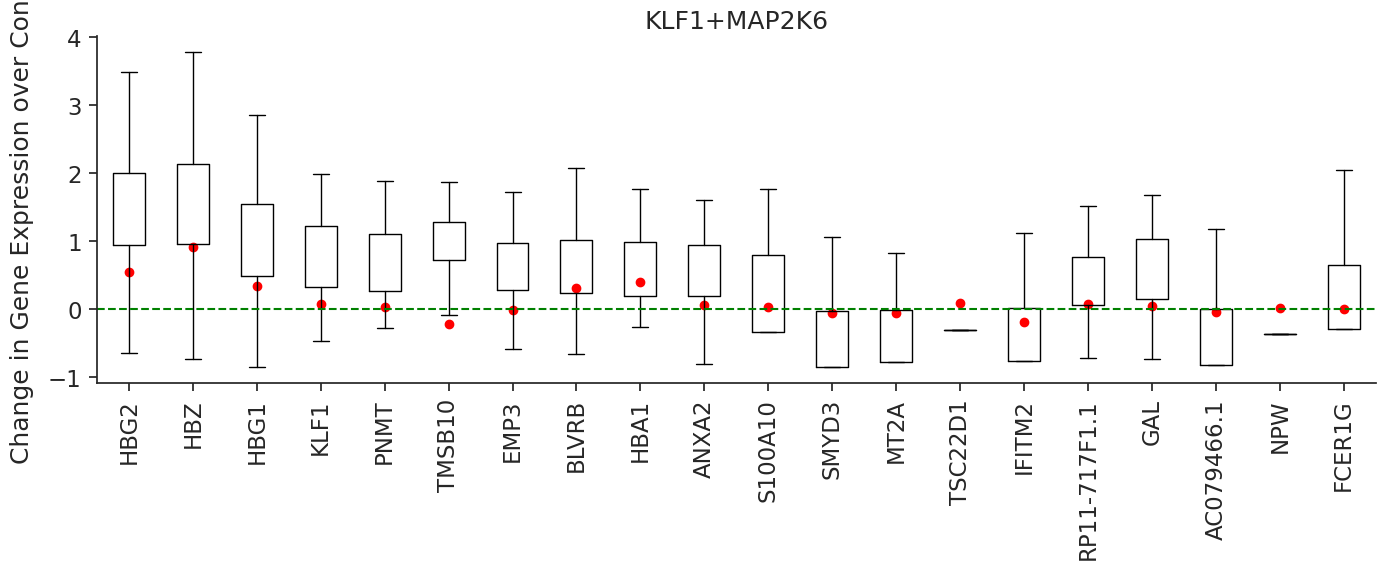

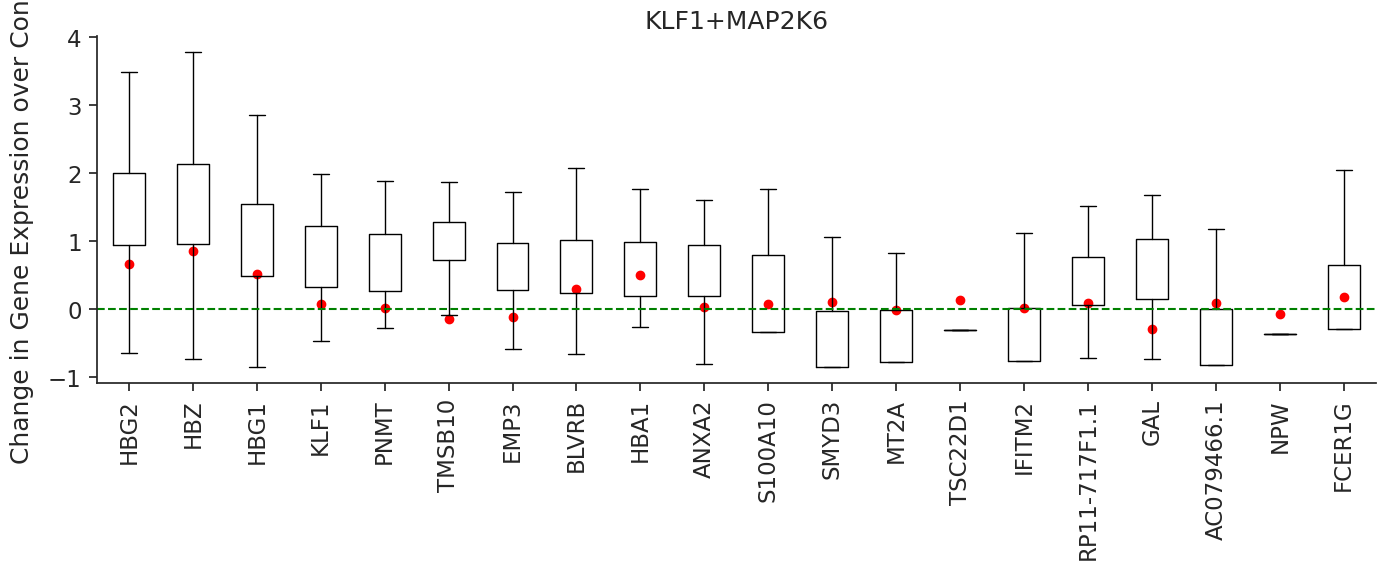

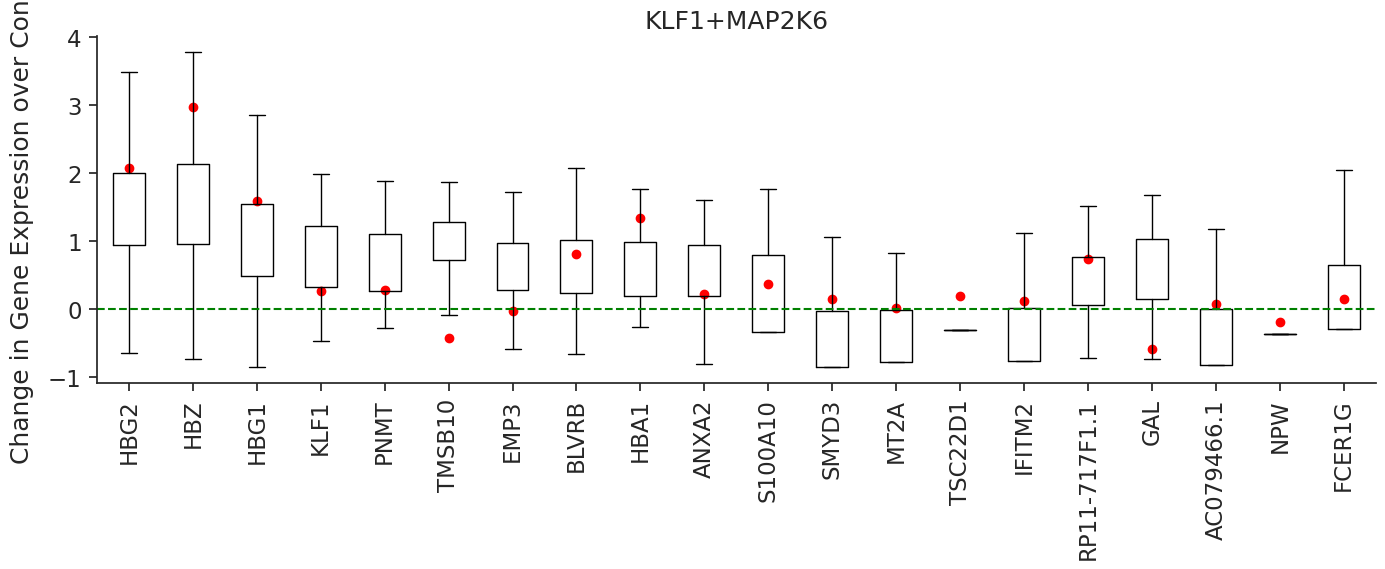

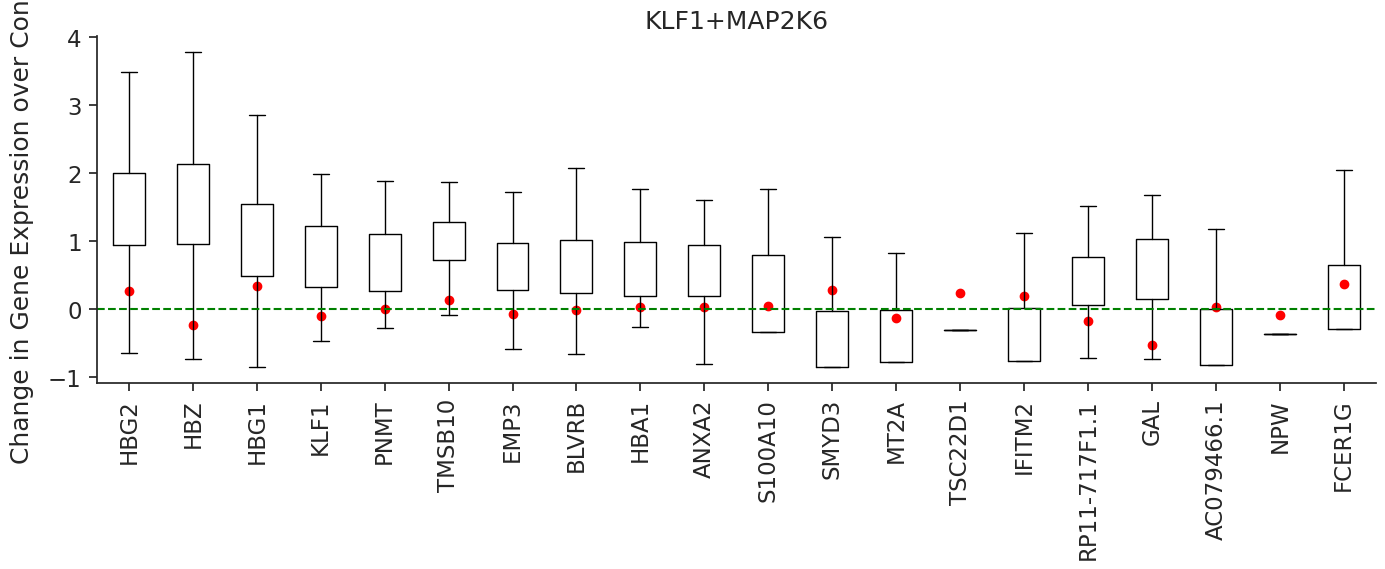

In [42]:
gears_model.plot_perturbation('KLF1+MAP2K6',"epoch20_control_pert.png")
gears_ising_model.plot_perturbation('KLF1+MAP2K6',"ising_sf_pert.png")
control_model.plot_perturbation('KLF1+MAP2K6',"epoch1_control_pert.png")
ising_model2.plot_perturbation('KLF1+MAP2K6', "ising_rand_pert.png")

In [263]:
#gears_ising_model.save_model('ising_model_sf')
#control_model.save_model('control_model')
#ising_model2.save_model('ising_model_rand')

In [28]:
real_ising = GEARS(pert_data, device = 'cuda')
real_ising.model_initialize(hidden_size = 64, ising = True, ising_lambda = 1, ising_cutoff = 1e-2, ising_temperature = 1000, ising_graph = torch.tensor(real_adj).cuda())

Found local copy...


In [31]:
importlib.reload(utils)
real_ising.train(epochs = 1, lr = 1e-3)

Start Training...
Epoch 1 Step 1 Train Loss: 0.4357
Epoch 1 Step 51 Train Loss: 0.4719
Epoch 1 Step 101 Train Loss: 0.5972
Epoch 1 Step 151 Train Loss: 0.4593
Epoch 1 Step 201 Train Loss: 0.5121
Epoch 1 Step 251 Train Loss: 0.4953
Epoch 1 Step 301 Train Loss: 0.4446
Epoch 1 Step 351 Train Loss: 0.4577
Epoch 1 Step 401 Train Loss: 0.5194
Epoch 1 Step 451 Train Loss: 0.5820
Epoch 1 Step 501 Train Loss: 0.5076
Epoch 1 Step 551 Train Loss: 0.4657
Epoch 1 Step 601 Train Loss: 0.4488
Epoch 1 Step 651 Train Loss: 0.4189
Epoch 1 Step 701 Train Loss: 0.4841
Epoch 1 Step 751 Train Loss: 0.4897
Epoch 1 Step 801 Train Loss: 0.4244
Epoch 1 Step 851 Train Loss: 0.5329
Epoch 1 Step 901 Train Loss: 0.4985
Epoch 1 Step 951 Train Loss: 0.4097
Epoch 1 Step 1001 Train Loss: 0.4664
Epoch 1 Step 1051 Train Loss: 0.3991
Epoch 1 Step 1101 Train Loss: 0.4857
Epoch 1 Step 1151 Train Loss: 0.5076
Epoch 1 Step 1201 Train Loss: 0.6110
Epoch 1 Step 1251 Train Loss: 0.6542
Epoch 1 Step 1301 Train Loss: 0.4207
Epoch 

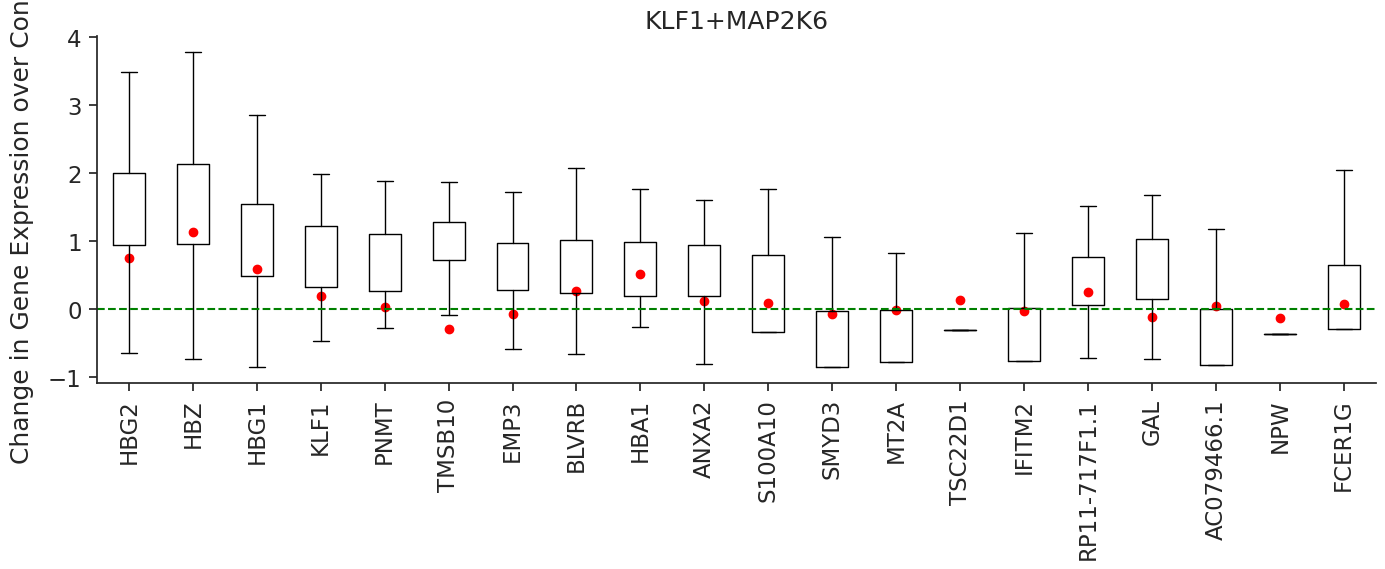

In [32]:
real_ising.plot_perturbation('KLF1+MAP2K6')

In [33]:
adj25 = np.load("adj_matrix_norman_25kb.npy")

In [34]:
real_25 = GEARS(pert_data, device = 'cuda')
real_25.model_initialize(hidden_size = 64, ising = True, ising_lambda = 1, ising_cutoff = 1e-2, ising_temperature = 1000, ising_graph = torch.tensor(adj25).cuda())

Found local copy...


In [36]:
real_25.train(epochs = 1, lr = 1e-3)

Start Training...
Epoch 1 Step 1 Train Loss: 0.5157
Epoch 1 Step 51 Train Loss: 0.4218
Epoch 1 Step 101 Train Loss: 0.5121
Epoch 1 Step 151 Train Loss: 0.5047
Epoch 1 Step 201 Train Loss: 0.4646
Epoch 1 Step 251 Train Loss: 0.4425
Epoch 1 Step 301 Train Loss: 0.5436
Epoch 1 Step 351 Train Loss: 0.4366
Epoch 1 Step 401 Train Loss: 0.4987
Epoch 1 Step 451 Train Loss: 0.5168
Epoch 1 Step 501 Train Loss: 0.5069
Epoch 1 Step 551 Train Loss: 0.5093
Epoch 1 Step 601 Train Loss: 0.5376
Epoch 1 Step 651 Train Loss: 0.4202
Epoch 1 Step 701 Train Loss: 0.4619
Epoch 1 Step 751 Train Loss: 0.4511
Epoch 1 Step 801 Train Loss: 0.4608
Epoch 1 Step 851 Train Loss: 0.4523
Epoch 1 Step 901 Train Loss: 0.4394
Epoch 1 Step 951 Train Loss: 0.4649
Epoch 1 Step 1001 Train Loss: 0.5306
Epoch 1 Step 1051 Train Loss: 0.4321
Epoch 1 Step 1101 Train Loss: 0.4206
Epoch 1 Step 1151 Train Loss: 0.4490
Epoch 1 Step 1201 Train Loss: 0.4823
Epoch 1 Step 1251 Train Loss: 0.3903
Epoch 1 Step 1301 Train Loss: 0.5605
Epoch 

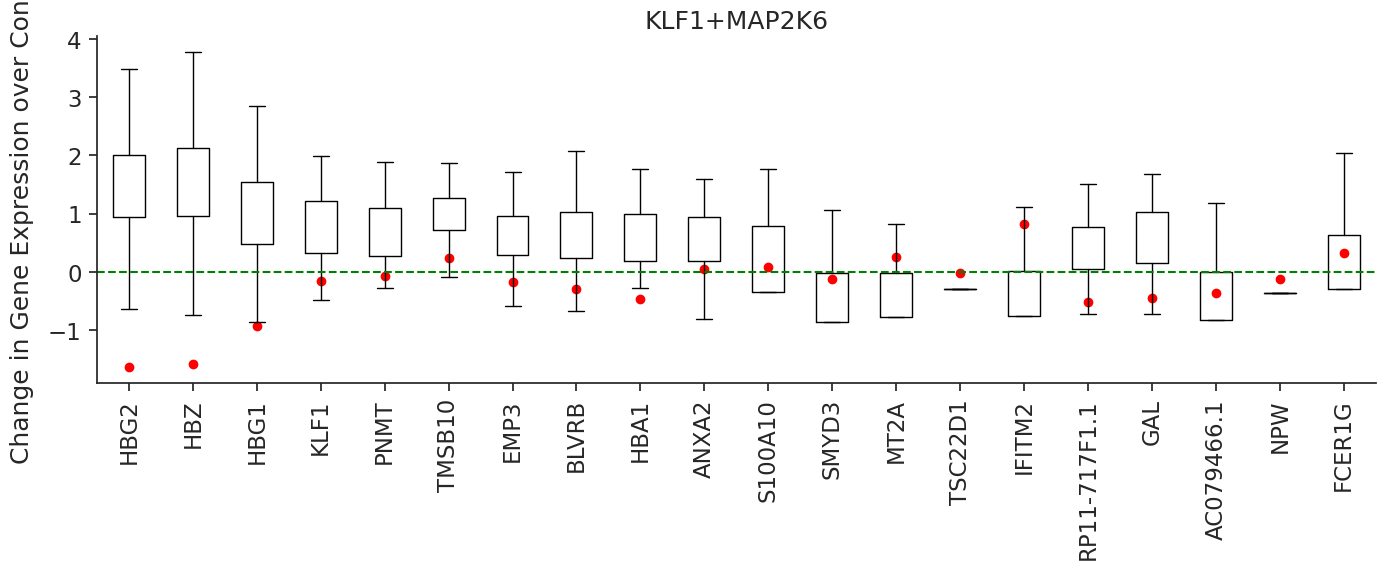

In [39]:
real_25.plot_perturbation('KLF1+MAP2K6')

In [56]:
import networkx as nx

(array([ 103.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0., 4942.]),
 array([   0.  ,   98.82,  197.64,  296.46,  395.28,  494.1 ,  592.92,
         691.74,  790.56,  889.38,  988.2 , 1087.02, 1185.84, 1284.66,
        1383.48, 1482.3 , 1581.12, 1679.94, 1778.76, 1877.58, 1976.4 ,
        2075.22, 2174.04, 2272.86, 2371.68, 2470.5 , 2569.32, 2668.14,
        2766.96, 2865.78, 2964.6 , 3063.42, 3162.24, 3261.06, 3359.88,
        3458.7 , 3557.52, 3656.34, 3755.16, 3853.98, 3952.8 , 4051.62,
        4150.44, 4249.26, 4348.08, 4446.9 , 4545.72, 4644.54, 4743.36,
        4842.18, 4941.  ]),
 <BarContainer object of 50 artists>)

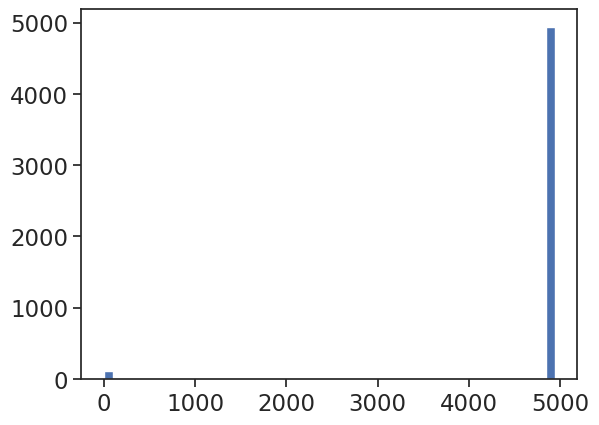

In [65]:
plt.hist((real_adj !=0).sum(0), bins = 50)

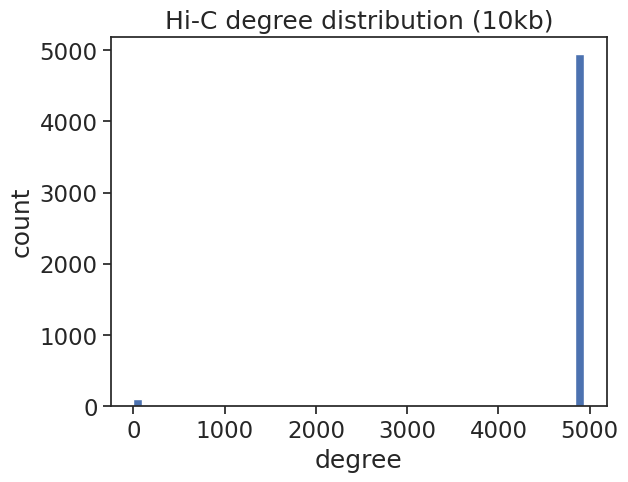

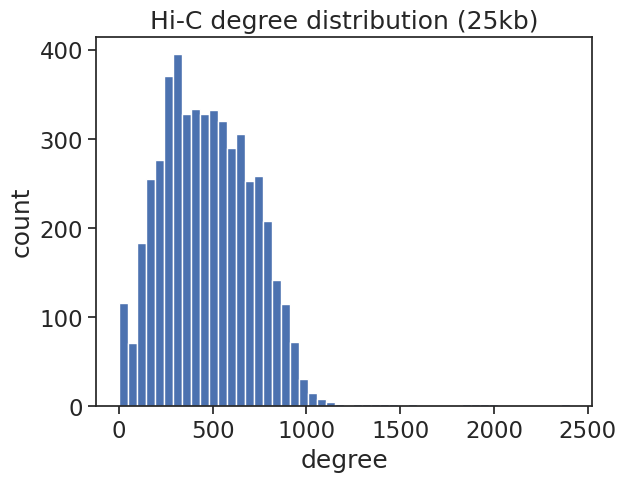

In [71]:
plt.hist((real_adj !=0).sum(0), bins = 50)
plt.title("Hi-C degree distribution (10kb)")
plt.xlabel("degree")
plt.ylabel("count")
plt.show()
plt.hist((adj25 !=0).sum(0), bins = 50)
plt.title("Hi-C degree distribution (25kb)")
plt.xlabel("degree")
plt.ylabel("count")
plt.show()